# Chapter 10 – Introduction to Artificial Neural Networks with Keras

This notebook contains all the code samples and solutions to the exercises in chapter 10 of *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition* (O'Reilly). *Note: all code examples are based on the author's original GitHub repository.*

**Assignment Instructions:**
Per the assignment guidelines, this notebook reproduces the code from Chapter 10. It also includes theoretical explanations and summaries for each concept, as required.

## Chapter Summary

This chapter introduces **Artificial Neural Networks (ANNs)**, which are at the core of Deep Learning. We begin with the biological inspiration (the neuron) and trace the history from the first **Perceptron** to modern **Multilayer Perceptrons (MLPs)**.

Key concepts covered include:
* **The Perceptron:** A simple ANN architecture based on a Threshold Logic Unit (TLU). We see how it makes predictions and its main limitation (e.g., it cannot solve the XOR problem)[cite: 284, 288].
* **Multilayer Perceptron (MLP):** By stacking Perceptrons (adding hidden layers), MLPs can solve complex problems[cite: 289]. We cover the crucial **backpropagation** algorithm used to train them[cite: 289].
* **Activation Functions:** We explain the need for non-linear activation functions (like ReLU, sigmoid, and tanh) to allow the network to learn complex patterns[cite: 291, 292].
* **Keras Implementation:** We build, train, and evaluate MLPs for both **classification** (using Fashion MNIST) and **regression** (using the California Housing dataset)[cite: 297, 307].
* **Keras APIs:** We explore the three main Keras APIs:
    1.  **Sequential API:** For simple stacks of layers[cite: 299].
    2.  **Functional API:** For building complex network architectures, such as Wide & Deep models with multiple inputs or outputs[cite: 308].
    3.  **Subclassing API:** For creating fully dynamic models by subclassing `keras.Model`[cite: 313].
* **Model Management:** We cover practical skills like saving/loading models, using callbacks for `ModelCheckpoint` and `EarlyStopping`, and visualizing learning curves with **TensorBoard**[cite: 314, 315, 317].
* **Hyperparameter Tuning:** Finally, we show how to wrap Keras models to use Scikit-Learn's `RandomizedSearchCV` for effective hyperparameter tuning and provide guidelines on choosing the number of layers, neurons, and other key parameters[cite: 320, 323, 324].

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 3.7 or later is required for the latest versions of Scikit-Learn), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## From Biological to Artificial Neurons

### Theoretical Explanation: The Perceptron

The **Perceptron**, invented in 1957 by Frank Rosenblatt, is one of the simplest ANN architectures. It is based on an artificial neuron called a **Threshold Logic Unit (TLU)**[cite: 284].

1.  **TLU Computation:** The TLU computes a weighted sum of its inputs ($z = \mathbf{w}^\top \cdot \mathbf{x} + b$) and then applies a **step function** to that sum to produce an output[cite: 284, 285]. For example, it might output 1 if $z$ is positive, and 0 otherwise.
2.  **Perceptron Architecture:** A Perceptron is composed of a single layer of TLUs, with each TLU connected to all the inputs (a *fully connected layer*)[cite: 285].
3.  **Training (Hebb's Rule):** The Perceptron is trained using a rule inspired by Hebb's rule ("Cells that fire together, wire together")[cite: 286]. The Perceptron learning rule reinforces connections that help reduce the error. When an output neuron produces a wrong prediction, it reinforces the connection weights from the inputs that would have contributed to the correct prediction[cite: 286, 287].
4.  **Limitations:** In 1969, Minsky and Papert highlighted that Perceptrons are incapable of solving some trivial problems, most famously the **XOR (Exclusive OR) classification problem**[cite: 288]. This is true for any linear classification model.

In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(int) # Iris setosa?

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])
print(y_pred)

[1]


### Theoretical Explanation: The Multilayer Perceptron (MLP) and Backpropagation

The limitations of the Perceptron were overcome by stacking multiple Perceptrons, creating a **Multilayer Perceptron (MLP)**. An MLP is composed of:
* An **input layer**
* One or more layers of TLUs, called **hidden layers**
* A final layer of TLUs called the **output layer** [cite: 289]

This architecture is a *feedforward neural network (FNN)* because the signal flows in only one direction. When an ANN contains a deep stack of hidden layers, it is called a **Deep Neural Network (DNN)**[cite: 289].

For many years, researchers struggled to train MLPs. The breakthrough came in 1986 with the **backpropagation** training algorithm[cite: 289, 290].

**Backpropagation (Training in a Nutshell):**
1.  **Forward Pass:** The algorithm feeds one mini-batch of data to the network. It computes the output of all neurons in each layer and passes the result to the next layer until it gets the final output. All intermediate results are preserved[cite: 290].
2.  **Measure Error:** The algorithm measures the network's output error using a loss function[cite: 290].
3.  **Backward Pass (Error Gradients):** It computes how much each output connection contributed to the error (using the chain rule). It then continues to measure the error contributions from each connection in the layer below, working backward until it reaches the input layer. This reverse pass efficiently measures the error gradient across all connection weights in the network[cite: 290, 291].
4.  **Gradient Descent Step:** Finally, the algorithm performs a Gradient Descent step to tweak all the connection weights and biases using the error gradients it just computed[cite: 291].

**Activation Functions:**
For backpropagation to work, the step function was replaced with a function that has a well-defined, non-zero derivative. This allows Gradient Descent to make progress.

* **Sigmoid (Logistic):** `σ(z) = 1 / (1 + exp(–z))`. Outputs a number between 0 and 1[cite: 291].
* **Hyperbolic Tangent (tanh):** `tanh(z) = 2σ(2z) – 1`. Outputs a number between -1 and 1. This range tends to help speed up convergence[cite: 291].
* **ReLU (Rectified Linear Unit):** `ReLU(z) = max(0, z)`. It is fast to compute and has become the default. It doesn't saturate for positive values, which helps reduce issues during Gradient Descent[cite: 292].

**Why are they needed?** If you chain several linear transformations (layers without an activation function), all you get is a single linear transformation. Without nonlinearity between layers, a deep network is equivalent to a single flat layer, which cannot solve complex problems[cite: 292].

### Theoretical Explanation: Regression and Classification MLPs

MLPs can be used for regression and classification with minor changes to the output layer.

#### Regression MLPs
* **Output Neurons:** One output neuron per value to predict (e.g., 1 for predicting a house price)[cite: 292, 293].
* **Output Activation:** No activation function, so the output is free to range from -∞ to +∞[cite: 293]. (If outputs must be positive, you can use ReLU or softplus; if they must be in a specific range, you can use logistic or tanh) [cite: 293].
* **Loss Function:** Mean Squared Error (MSE) is typical. If you have many outliers, you might use Mean Absolute Error (MAE) or Huber loss[cite: 293].

#### Classification MLPs
* **Binary Classification:** One output neuron using the **logistic (sigmoid)** activation function. The output is a probability (0 to 1) of being in the positive class[cite: 294].
* **Multilabel Classification:** (e.g., spam *and* urgent). One output neuron *for each* positive class, each using the **logistic (sigmoid)** activation function[cite: 294].
* **Multiclass Classification:** (e.g., digits 0-9). One output neuron *for each class*. The entire output layer must use the **softmax** activation function, which ensures all probabilities are between 0 and 1 and sum up to 1[cite: 294].
* **Loss Function:** For all classification tasks, **cross-entropy** (also called log loss) is the appropriate loss function[cite: 295].

## Implementing MLPs with Keras

### Installing TensorFlow 2
The book assumes you have installed TensorFlow. If not, you can run:
`pip install -U tensorflow`

In [4]:
import tensorflow as tf
from tensorflow import keras
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.19.0
Keras version: 3.10.0


## Building an Image Classifier Using the Sequential API

### Code Reproduction: Load and Prepare Fashion MNIST Data

Keras provides helper functions to load many common datasets, including Fashion MNIST. We will load it, split it into training, validation, and test sets, and scale the pixel intensities to the 0–1 range[cite: 297, 298].

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# Print shape and data type
print("X_train_full shape:", X_train_full.shape)
print("X_train_full dtype:", X_train_full.dtype)

# Create a validation set and scale the data (dividing by 255.0)
# Scaling is important for Gradient Descent
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

# Define the class names
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

print("Class name for first training image:", class_names[y_train[0]])

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train_full shape: (60000, 28, 28)
X_train_full dtype: uint8
Class name for first training image: Coat


### Code Reproduction: Creating the model using the Sequential API

Now let's build the neural network. This is the simplest kind of Keras model, a single stack of layers connected sequentially[cite: 299].

1.  **`Flatten` layer:** This first layer converts each 28x28 input image into a 1D array of 784 pixels. It's a simple preprocessing step with no parameters[cite: 299].
2.  **`Dense` hidden layers:** We add two hidden layers with 300 and 100 neurons, respectively. Both use the **ReLU** activation function[cite: 299].
3.  **`Dense` output layer:** The final layer has 10 neurons (one per class) and uses the **softmax** activation function, because the classes are exclusive (an image can't be both a shirt and a sandal)[cite: 299].

In [6]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Display the model's summary
model.summary()

# Note: The first Dense layer has 784 × 300 weights + 300 biases = 235,500 parameters[cite: 301].

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# We can also inspect the layers
print(model.layers)
hidden1 = model.layers[1]
print(hidden1.name)

# We can get the weights and biases of a layer
weights, biases = hidden1.get_weights()
print("Weights shape:", weights.shape)
print("Biases shape:", biases.shape)

[<Flatten name=flatten, built=True>, <Dense name=dense, built=True>, <Dense name=dense_1, built=True>, <Dense name=dense_2, built=True>]
dense
Weights shape: (784, 300)
Biases shape: (300,)


### Code Reproduction: Compiling the model

After creating a model, you must call its `compile()` method to specify the loss function, optimizer, and metrics[cite: 302].

* **Loss:** We use `"sparse_categorical_crossentropy"` because we have *sparse* labels (just the target class index, from 0 to 9). If we had one-hot vectors for labels, we would use `"categorical_crossentropy"`[cite: 302].
* **Optimizer:** `"sgd"` tells Keras to use Stochastic Gradient Descent (i.e., backpropagation)[cite: 303].
* **Metrics:** We ask for `"accuracy"` since this is a classifier[cite: 303].

In [9]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

### Code Reproduction: Training and evaluating the model

Now we can train the model by calling its `fit()` method. We pass the training data, the number of epochs, and the validation set. Keras will measure the loss and metrics on the validation set at the end of each epoch, which is very useful to see if the model is overfitting[cite: 303].

In [10]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6852 - loss: 0.9858 - val_accuracy: 0.8276 - val_loss: 0.5119
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8263 - loss: 0.4981 - val_accuracy: 0.8476 - val_loss: 0.4522
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8433 - loss: 0.4463 - val_accuracy: 0.8550 - val_loss: 0.4221
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8531 - loss: 0.4167 - val_accuracy: 0.8628 - val_loss: 0.4021
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8602 - loss: 0.3955 - val_accuracy: 0.8672 - val_loss: 0.3874
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8663 - loss: 0.3793 - val_accuracy: 0.8702 - val_loss: 0.3762
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8706 - loss: 0.3658 - val_accuracy: 0.8706 - val_loss: 0.3675
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8737 - loss: 0.3541 - 

The `fit()` method returns a `History` object containing training parameters, the list of epochs, and a dictionary (`history.history`) with the loss and metrics on the training and validation sets at the end of each epoch[cite: 304]. We can use this to plot the learning curves.

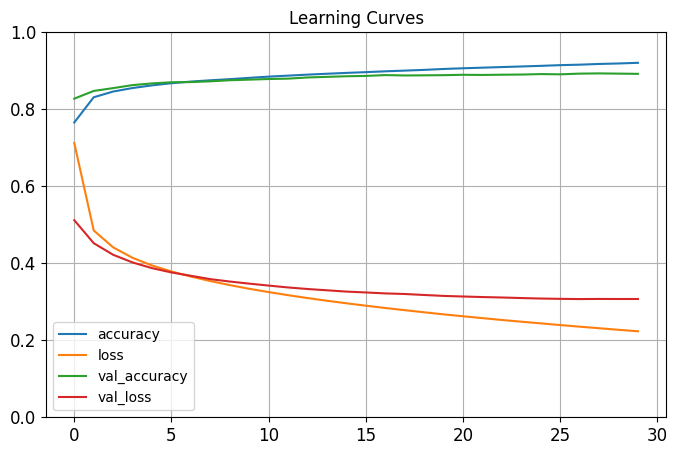

In [11]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title("Learning Curves")
plt.show()

The validation curves are close to the training curves, which indicates there isn't significant overfitting. The validation loss is still going down, so we could probably continue training.

Now, let's evaluate the model on the test set to estimate the generalization error.

In [12]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8760 - loss: 0.3528


[0.3520641028881073, 0.8765000104904175]

### Code Reproduction: Using the model to make predictions

We can use the `predict()` method to get the list of class probabilities for each instance. The model outputs one probability per class for each instance[cite: 1211].

In [13]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

If you only care about the class with the highest probability, you can use `predict_classes()` instead[cite: 1211].

In [14]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
print("Predictions:", y_pred)
print("Class names:", np.array(class_names)[y_pred])
print("Actual classes:", y_test[:3])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predictions: [9 2 1]
Class names: ['Ankle boot' 'Pullover' 'Trouser']
Actual classes: [9 2 1]


## Building a Regression MLP Using the Sequential API

### Theoretical Explanation & Code

Let's switch to the California housing problem. This is a regression task, so the architecture will be different:
1.  **Output Layer:** It will have a single neuron (we are predicting a single value, the price)[cite: 308].
2.  **Output Activation:** No activation function is used[cite: 308].
3.  **Loss Function:** We use the `"mean_squared_error"` (MSE) loss[cite: 308].

We will load the data, split it, and scale it using Scikit-Learn's `StandardScaler`[cite: 1212].

In [15]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [17]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test[:3])
print("Test MSE:", mse_test)
print("Predictions:", y_pred)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 3.8242 - val_loss: 1.0326
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7909 - val_loss: 0.6508
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6834 - val_loss: 0.5908
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6389 - val_loss: 0.5534
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6056 - val_loss: 0.5272
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5790 - val_loss: 0.5055
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5572 - val_loss: 0.4883
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5392 - val_loss: 0.4750
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5244 - val_loss: 0.4639
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.5121 - val_loss: 0.4550
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5018 - val_loss: 0.4477
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

## Building Complex Models Using the Functional API

### Theoretical Explanation: Wide & Deep Networks

The `Sequential` API is easy to use, but it's not flexible enough for complex topologies, such as a **Wide & Deep network**[cite: 308].

This architecture connects all or part of the inputs directly to the output layer (the *short path*), while also running them through a normal stack of hidden layers (the *deep path*)[cite: 308]. This allows the network to learn both simple rules (via the short path) and deep, complex patterns (via the deep path)[cite: 308].

To build this, we use the **Functional API**:
1.  Create an `Input` object, specifying the shape and dtype.
2.  Create layers and call them like functions, passing them the previous layer's output.
3.  Use `keras.layers.Concatenate()` to concatenate the inputs from the short path and deep path.
4.  Create a `keras.Model`, specifying the `inputs` and `outputs`.

In [18]:
# Code Reproduction: Wide & Deep Network (Functional API)

input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_], outputs=[output])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 30)        │        270 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 30)        │        930 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38)        │          0 │ input_layer_3[0]… │
│ (Concatenate)       │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         39 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,239 (4.84 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 0 (0.00 B)

### Theoretical Explanation & Code: Handling Multiple Inputs

What if you want to send *different* subsets of features through the wide and deep paths? The Functional API makes this easy.

1.  Create multiple `Input` layers (e.g., `input_A` and `input_B`).
2.  Build the rest of the model, connecting layers as needed.
3.  When creating the `Model`, pass a list of inputs: `inputs=[input_A, input_B]`.
4.  When calling `fit()`, pass a tuple of input matrices: `fit((X_train_A, X_train_B), y_train, ...)`[cite: 311].

In [20]:
# Example: Send features 0-4 (wide) and 2-7 (deep)
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.Model(inputs=[input_A, input_B], outputs=[output])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

# Create the input subsets
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))

mse_test = model.evaluate((X_test_A, X_test_B), y_test)
print("Test MSE:", mse_test)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0388 - val_loss: 1.1575
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9695 - val_loss: 0.7270
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7412 - val_loss: 0.6380
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6729 - val_loss: 0.5904
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6362 - val_loss: 0.5585
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6100 - val_loss: 0.5341
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5889 - val_loss: 0.5144
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5710 - val_loss: 0.4977
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5552 - val_loss: 0.4831
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5411 - val_loss: 0.4699
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5282 - val_loss: 0.4586
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

### Theoretical Explanation & Code: Handling Multiple Outputs

You might also want multiple outputs:
* **Multitask Output:** (e.g., locate *and* classify an object)[cite: 311].
* **Regularization:** An auxiliary output can be added to a lower layer (like in the GoogLeNet architecture). This encourages the lower part of the network to learn useful features on its own, acting as a form of regularization[cite: 311].

To implement this, you define the outputs in the `Model` as a list: `outputs=[output, aux_output]`.

When compiling, you must provide a **list of losses** and **loss weights** to control the importance of each loss[cite: 312].

In [26]:
# Build the model with a main output and an auxiliary output
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.Model(inputs=[input_A, input_B],
                  outputs=[output, aux_output])

# Compile with multiple losses and loss weights
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

# Train by providing labels for both outputs
history = model.fit(
    (X_train_A, X_train_B),
    (y_train, y_train), # Main and Aux targets are the same
    epochs=20,
    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid))
)

# Evaluate returns the total loss and all individual losses
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
print(f"Total Loss: {total_loss}, Main Loss: {main_loss}, Aux Loss: {aux_loss}")

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - aux_output_loss: 5.6582 - loss: 3.4692 - main_output_loss: 3.2260 - val_aux_output_loss: 6.4046 - val_loss: 2.9399 - val_main_output_loss: 2.5536
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - aux_output_loss: 3.5505 - loss: 1.0948 - main_output_loss: 0.8220 - val_aux_output_loss: 4.1242 - val_loss: 1.3955 - val_main_output_loss: 1.0918
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - aux_output_loss: 2.5711 - loss: 0.8794 - main_output_loss: 0.6914 - val_aux_output_loss: 2.9743 - val_loss: 0.9377 - val_main_output_loss: 0.7112
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - aux_output_loss: 2.0710 - loss: 0.7915 - main_output_loss: 0.6494 - val_aux_output_loss: 2.3522 - val_loss: 0.7784 - val_main_output_loss: 0.6033
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - aux_output_loss: 1.8002 - loss: 0.7419 - main_output_loss: 0.6243 - val_aux_output_loss: 1.9949 - val_loss: 0.7051 - val_main_output_loss: 0.5615


## Using the Subclassing API to Build Dynamic Models

### Theoretical Explanation

Both the Sequential and Functional APIs are *declarative*: you define the static graph of layers first, and then run data through it. This is great for analysis, saving, and error-checking[cite: 313].

However, sometimes you need a **dynamic model** (e.g., with loops or conditional branching). For this, you can use the **Subclassing API**:
1.  Subclass `keras.Model`.
2.  Create the layers you need in the constructor (`__init__()`).
3.  Perform the computations (the "forward pass") in the `call()` method. Here, you can use `for` loops, `if` statements, and any Python logic you need[cite: 313].

**Trade-off:** This provides maximum flexibility, but Keras cannot easily inspect or save the model's architecture, and it's harder to debug[cite: 314].

In [22]:
class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs) # handles standard args (e.g., name)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)

    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

# Create an instance
model = WideAndDeepModel(30, "relu")
# We can then compile, fit, and evaluate it just like the Functional API model

## Saving and Restoring a Model

### Theoretical Explanation & Code

Saving a Sequential or Functional model is simple. Keras saves the model’s architecture, the values of all model parameters (weights and biases), and the optimizer (including its state) in a single HDF5 (`.h5`) file[cite: 314].

**Note:** This does *not* work for subclassed models. For those, you must use `save_weights()` and `load_weights()` and re-build the architecture manually[cite: 315].

In [23]:
# Rebuild a simple model for this demo
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

# Save the model
model.save("my_keras_model.h5")

# Load the model
model_loaded = keras.models.load_model("my_keras_model.h5")

# Check that it works
mse_test = model_loaded.evaluate(X_test, y_test)
print("Loaded model test MSE:", mse_test)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Argument(s) not recognized: {'lr': 0.001}

## Using Callbacks

### Theoretical Explanation

The `fit()` method accepts a `callbacks` argument that lets you specify a list of objects Keras will call at the start and end of training, epochs, and batches[cite: 315].

* **`ModelCheckpoint`:** Saves checkpoints of your model at regular intervals (e.g., at the end of each epoch). Setting `save_best_only=True` is a great practice: it will only save your model when its performance on the validation set is the best so far[cite: 315].
* **`EarlyStopping`:** Interrupts training when it measures no progress on the validation set for a number of epochs (defined by `patience`). By setting `restore_best_weights=True`, it will automatically roll back to the best model at the end of training[cite: 315, 316].
* **Custom Callbacks:** You can write your own by subclassing `keras.callbacks.Callback` and implementing methods like `on_epoch_end`, `on_batch_begin`, etc.[cite: 316].

In [ ]:
# Rebuild a model for this demo
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

# Create the callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_best_model.h5", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

# The model is now the one with the best validation performance
mse_test = model.evaluate(X_test, y_test)
print("Best model test MSE:", mse_test)

## Using TensorBoard for Visualization

### Theoretical Explanation

**TensorBoard** is an interactive visualization tool that lets you view learning curves, compare runs, visualize the model graph, analyze training statistics, and more[cite: 317].

It works by reading binary log files called **event files**. Your program needs to write to these files during training.

The simplest way to do this is to use the `keras.callbacks.TensorBoard` callback. We'll set it up to write to a unique, timestamped log directory for each run[cite: 317].

In [ ]:
import os
import time

root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
print("Log directory:", run_logdir)

In [24]:
# Rebuild a model for this demo
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

# Create the TensorBoard callback
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

ValueError: Argument(s) not recognized: {'lr': 0.001}

### Launching TensorBoard

To view the logs, you can launch the TensorBoard server from a terminal:

`$ tensorboard --logdir=./my_logs --port=6006`

Or you can run it directly within Jupyter/Colab using the following magic commands:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

## Fine-Tuning Neural Network Hyperparameters

### Theoretical Explanation

The flexibility of neural networks is also their main drawback: there are many hyperparameters to tune. How do you find the best combination?

We can use Scikit-Learn's hyperparameter tuning tools (`GridSearchCV` or `RandomizedSearchCV`). To do this, we must wrap our Keras models in objects that mimic regular Scikit-Learn regressors[cite: 320].

1.  Create a `build_model()` function that builds and compiles a Keras model, given a set of hyperparameters.
2.  Wrap this function using `keras.wrappers.scikit_learn.KerasRegressor` (or `KerasClassifier`).
3.  Use this wrapper object in `RandomizedSearchCV` just like any other Scikit-Learn estimator.

In [25]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

# 1. Create the build_model() function
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

# 2. Create the KerasRegressor wrapper
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

# 3. Use RandomizedSearchCV
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

# We pass Keras-specific args (like epochs and callbacks) to fit()
# These will be passed to the underlying Keras model.
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, random_state=42)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

# Show the best parameters and score
print("Best parameters found:", rnd_search_cv.best_params_)
print("Best score (neg MSE):", rnd_search_cv.best_score_)

# Get the best model
model = rnd_search_cv.best_estimator_.model

AttributeError: module 'keras.wrappers' has no attribute 'scikit_learn'

### Theoretical Explanation: Hyperparameter Guidelines

While there are many libraries to automate tuning (Hyperopt, Keras Tuner, etc.), it helps to have a good starting point.

* **Number of Hidden Layers:** For many problems, 1 or 2 hidden layers is enough. For more complex problems, you can ramp up the number of layers until you start overfitting. For very complex tasks, it's better to use **transfer learning** (reusing the lower layers of a pretrained network) than to train a large network from scratch[cite: 323, 324].
* **Number of Neurons per Layer:** A common practice used to be a pyramid (fewer neurons at each layer). A more modern approach is to use the **same number of neurons** in all hidden layers, as this is one less hyperparameter to tune[cite: 324, 325]. A good strategy is to pick a model with more layers and neurons than you need (the "stretch pants" approach) and then use early stopping and regularization to prevent overfitting[cite: 325].
* **Learning Rate:** This is often the most important hyperparameter. A good starting point is often found by increasing the rate exponentially, plotting the loss, and picking a rate slightly lower than where the loss shoots up[cite: 325].
* **Optimizer, Batch Size, Activation:** These are also key parameters to tune. ReLU (or its variants, see Ch 11) is a good default for hidden layers. Using early stopping means you don't need to tune the number of iterations[cite: 325, 326].

## Exercises

From Chapter 10, page 327:

1.  Use the TensorFlow Playground to train several binary classifiers... to gain some intuition on how neural networks work...
2.  Draw an ANN using the original artificial neurons... that computes A ⊕ B (XOR).
3.  Why is it generally preferable to use a Logistic Regression classifier rather than a classical Perceptron?
4.  Why was the logistic activation function a key ingredient in training the first MLPs?
5.  Name three popular activation functions. Can you draw them?
6.  Suppose you have an MLP... What is the shape of the input matrix X? ... What are the shapes of the hidden layer’s weight vector... and its bias vector? ... What is the shape of the network’s output matrix Y? ... Write the equation that computes the network’s output matrix Y.
7.  How many neurons do you need in the output layer if you want to classify email into spam or ham? ... What about for MNIST? ... What about for predicting housing prices?
8.  What is backpropagation and how does it work? What is the difference between backpropagation and reverse-mode autodiff?
9.  Can you list all the hyperparameters you can tweak in a basic MLP? If the MLP overfits... how could you tweak these hyperparameters...?
10. Train a deep MLP on the MNIST dataset. See if you can get over 98% precision. Try searching for the optimal learning rate... Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.